# Lecture 8

## Function approximation with global functions

Consider a generic function in one dimension $u(x)$. $u(x)$ can be anything, a polynomial, harmonic, exponential, etc., and it can be defined on the entire real line $x \in \mathbb{R}$ or simply a part of it $x \in [a, b]$ for some real numbers $a < b$. Sometimes you will see a notation like $u(x): [a, b] \rightarrow \mathbb{R}$. This means that the function $u(x)$ is defined on the domain $x\in[a,b]$ and outputs a real number.   

We now want to approximate this function $u(x)$ using other functions $\psi_j(x)$, such that

$$
u(x) = \sum_{k=0}^N \hat{u}_k \psi_k(x).
$$

The other functions $\psi_j(x)$ are called basis functions. The basis functions can also be anything, but they need to output the same kind of number as $u(x)$. That is, if $u(x)$ is a complex function, then $\psi_j(x)$ better be  a complex function as well.

A basis is a collection (or set) of basis functions

$$
\{\psi_j(x)\}_{j=0}^N.
$$

A functionspace $V_N$ can be defined as the span of a this set of basis functions

$$
V_N = \text{span}\{\psi_j\}_{j=0}^N.
$$

For example, $V_N = \text{span}\{x^j\}_{j=0}^{N}$ is the space of all polynomials of order less than or equal to $N$.

If we say that the function $u_N \in V_N$, this means that we can write

$$
u_N(x) = \sum_{j=0}^N \hat{u}_j \psi_j(x).
$$

The set $\boldsymbol{\hat{u}} = \{\hat{u}_j\}_{j=0}^N$ contains the expansion coefficients. These coefficients are the unknown when we are working with function approximation, or later, the finite element method.

Consider a very simple example. Let $u(x) = 10(x-1)^2-1$ for $x\in [1,2]$. We can create the function in Sympy and plot it

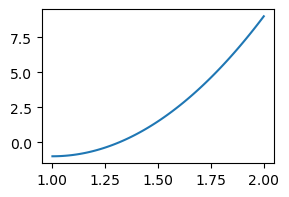

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

x = sp.Symbol('x')
u = 10*(x-1)**2-1
N = 100
xj = np.linspace(1, 2, N)
plt.figure(figsize=(3, 2))
plt.plot(xj, sp.lambdify(x, u)(xj));

Now create a functionspace consisting of all straight lines

$$
V = \text{span}\{1, x\}
$$

and try to find the approximation $u_N \in V$ that is the best approximation of $u(x)$. How can we do this? All we know is that

$$
u_N(x) = \hat{u}_0 + \hat{u}_1 x.
$$

How do we find $\{\hat{u}_0, \hat{u}_1\}$ such that $u_N(x)$ is the best possible approximation to $u(x)$? 

There are several possible approaches. The three approaches considered in the [book](https://link-springer-com.ezproxy.uio.no/book/10.1007/978-3-030-23788-2) are 

* The least squares method
* The Galerkin method
* The collocation method (interpolation)

We will briefly mention the least squares method and focus on the last two. All methods will allow us to find the best possible $u_N(x)$, but with slightly different approaches. All methods will provide us with $N+1$ equations that can be used to find the $N+1$ unknown $\{\hat{u}_j\}_{j=0}^N$.

For the first two methods we need to define the $L^2$ inner product

$$
\left(f, g \right) = \int_{\Omega} f(x)g(x) dx,
$$

for two real functions $f(x)$ and $g(x)$ (complex functions have a slightly different inner product). The symbol $\Omega$ here represents the domain of interest. For our first example $\Omega = [1, 2]$. 

```{note}
Sometimes the inner product is written as $\left(f, g \right)_{L^2(\Omega)}$, in order to clarify that it is the $L^2$ inner product on a certain domain. Sometimes the inner product is also called the scalar product.
```

The inner product is used in defining the $L^2$ error norm. If we define the error in the approximation as

$$
e(x) = u(x)-u_N(x),
$$

then the $L^2$ error norm is $\sqrt{(e, e)} = |e|$, or sometimes $|e|_{L^2}$. We will also use

$$
E = (e, e).
$$

For convenience we define a Python function for the inner product of Sympy functions:

In [2]:
def inner(u, v, domain=(-1, 1), x=x):
    return sp.integrate(u*v, (x, domain[0], domain[1]))

### The least squares method 

The least squares method requires that we solve

$$
\frac{\partial E}{\partial \hat{u}_j} = 0, \quad j \in (0, 1, \ldots, N).
$$

This gives us $N+1$ equations for the $N+1$ unknown $\{\hat{u}_j\}_{j=0}^{N}$. For our example, this is a lot of work by hand, but easily achieved using Sympy.

Find and display the two equations:

In [3]:
from IPython.display import display
u0, u1 = sp.symbols('u0,u1')
err = u-(u0+u1*x)
E = inner(err, err, (1, 2))
eq1 = sp.Eq(sp.diff(E, u0, 1), 0)
eq2 = sp.Eq(sp.diff(E, u1, 1), 0)
display(eq1)
display(eq2)

Eq(2*u0 + 3*u1 - 14/3, 0)

Eq(3*u0 + 14*u1/3 - 26/3, 0)

Solve the two equations for the two unknown `u0` and `u1`

In [4]:
uhat = sp.solve((eq1, eq2), (u0, u1))
uhat

{u0: -38/3, u1: 10}

Finally, plot the function $u(x)=10(x-1)^2-1$ and the best approximation $u_N(x) \in \text{span}\{1, x\}$ according to the least squares method.

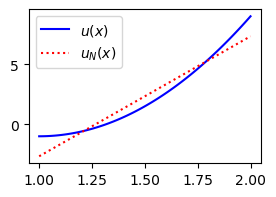

In [5]:
plt.figure(figsize=(3, 2))
plt.plot(xj, sp.lambdify(x, u)(xj), 'b', xj, uhat[u0]+uhat[u1]*xj, 'r:')
plt.legend(['$u(x)$', '$u_{N}(x)$']);

### The Galerkin method

The Galerkin method requires that the error is orthogonal to the basis functions (for the $L^2$ inner product). That is

$$
(e, \psi_j) = 0, \quad \forall \, j \in (0, 1, \ldots, N).
$$

This is not as much work as the least squares method, and even easier to implement in Sympy:

In [6]:
eq1 = sp.Eq(inner(err, 1, (1, 2)), 0)
eq2 = sp.Eq(inner(err, x, (1, 2)), 0)
display(eq1)
display(eq2)

Eq(-u0 - 3*u1/2 + 7/3, 0)

Eq(-3*u0/2 - 7*u1/3 + 13/3, 0)

In [7]:
sp.solve((eq1, eq2), (u0, u1))

{u0: -38/3, u1: 10}

```{note}
For function approximations the Galerkin method always gives the same result as the least squares method. However, the same does not apply when solving PDEs.
```

The Galerkin method can be formulated as:

Find $u_N \in V$ such that

$$
(e, v) = 0, \quad \forall \, v \in V,
$$

which means exactly the same as:

Find $u_N \in V$ such that

$$
(e, \psi_i) = 0, \quad \forall \, i \in (0, 1, \ldots, N).
$$

Inserting for $e=u-u_N$ and $u_N=\sum_{j=0}^N \hat{u}_j \psi_j$ we get

$$
(u - \sum_{j=0}^N \hat{u}_j \psi_j, \psi_i) = 0, \quad \forall \, i \in (0, 1, \ldots, N),
$$

and thus

$$
\sum_{j=0}^N (\psi_j, \psi_i) \, \hat{u}_j = (u, \psi_i), \quad \forall \, i \in (0, 1, \ldots, N).
$$

This is a linear algebra system, 

$$
A \boldsymbol{x} = \boldsymbol{b},
$$

where the matrix $A = (a_{ij})_{i,j=0}^N, a_{ij} = (\psi_j, \psi_i)$ and the vectors $\boldsymbol{x} = \{\hat{u}_i\}_{i=0}^N$ and $\boldsymbol{b}  = \{b_i\}_{i=0}^N, b_i = (u, \psi_i)$.

```{note}
The matrix $A$, including only the basis functions and no derivatives, is often called the *mass matrix*.
```

```{note}
In the Galerkin literature, the basis function containing the row index (i.e., $\psi_i$) is usually referred to as the *test* function, whereas the basis function containing the column index (i.e., $\psi_j$) is referred to as the *trial* function. Sometimes the entire $u_N(x)$ is called the trial function. The function $v$ above is a test function.
```

If the basis functions are chosen as orthonormal to each other, then

$$
(\psi_j, \psi_i) = \delta_{ij} = \begin{cases}
1 \text{ if } i = j, \\
0 \text{ if } i \ne j.
\end{cases}
$$

In that case we simply get

$$
\boldsymbol{x} = \boldsymbol{b} \quad \text{or} \quad \hat{u}_i = (u, \psi_i) \quad \forall \, i \in (0, 1, \ldots, N).
$$

It is more common that the basis functions are *orthogonal*. In this case the mass matrix becomes

$$
(\psi_j, \psi_i) = |\psi_i|^2 \delta_{ij}.
$$

We can still easily solve the linear algebra system (because $A$ is a diagonal matrix)

$$
\hat{u}_i = \frac{(u, \psi_i)}{|\psi_i|^2} \quad \forall \, i \in (0, 1, \ldots, N).
$$

The monomial basis

$$
\{x^n | n \in \mathbb{N} \}
$$

is a basis for the space of all polynomials. However, it is not a good basis. This is because the basis functions are not orthogonal and the mass matrix $A$ is ill conditioned.

A much better polynomial basis are the Legendre polynomials that are defined on the domain $\Omega = [-1, 1]$ as

$$
\begin{align*}
P_0(x) &= 1, \\
P_1(x) &= x, \\
P_2(x) &= \frac{1}{2}(3x^2-1), \\
&\vdots \\
(j+1)P_{j+1} &= (2j+1)xP_{j} - j P_{j-1}
\end{align*}
$$

The first 5 Legendre polynomials are plotted below

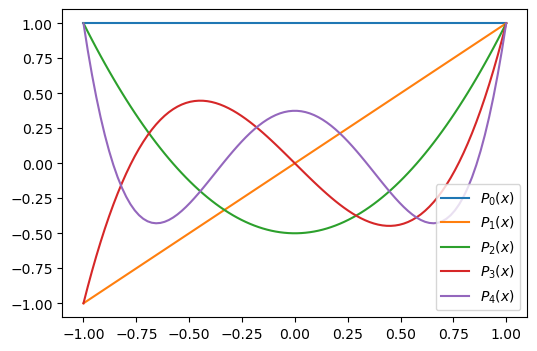

In [8]:
plt.figure(figsize=(6, 4))
xj = np.linspace(-1, 1, 100)
legend = []
p = np.zeros(100)
for n in range(5):
    l = sp.legendre(n, x)
    p[:] = sp.lambdify(x, l)(xj)
    plt.plot(xj, p)
    legend.append(f'$P_{n}(x)$')
plt.legend(legend);

The Legendre polynomials are $L^2$ orthogonal on $\Omega=[-1, 1]$

$$
(P_j, P_i) =  \frac{2}{2j+1}\delta_{ij}.
$$ (eq-legortho)

A slightly complicating factor, though, is that the computational domain needs to be $[-1, 1]$. So if the actual domain of $u(x)$ is $[a, b]$, then this needs to be mapped to the computational domain $[-1, 1]$. 

```{note}
Mapping from a physical to a computational (reference) domain is very common and it is best to get used to it sooner rather than later. With the finite element method this mapping is used all the time and it is described as one of the first topics for the method in Sec 3.1.8 of [Introduction to Numerical Methods for Variational Problems](https://link-springer-com.ezproxy.uio.no/book/10.1007/978-3-030-23788-2).
```

```{note}
The Legendre polynomials are not the only basis functions that require a mapping. The Bernstein polynomials (see, Sec. 2.4.3 in the [book](https://link-springer-com.ezproxy.uio.no/book/10.1007/978-3-030-23788-2)) use a computational domain $[0, 1]$. The computational domain depends on the chosen basis function.
```

Let $X$ be the coordinate in the computational (reference) domain $[A, B]$, where $A$ and $B$ are real numbers. A linear (affine) mapping, from the computational coordinate $X$ to the physical coordinate $x$ is then

$$
\begin{equation}
x = a + \frac{b-a}{B-A}(X-A).
\end{equation}
$$(eq-x)

The reverse mapping is

$$
\begin{equation}
X = A + \frac{B-A}{b-a}(x-a).
\end{equation}
$$(eq-xmap)

These mappings are valid for any basis function. 

```{note}
When using a basis function like $\psi_k(x) = \sin((k+1) \pi x), x \in [0, 1]$, you are implicitly mapping the physical domain $[0, 1]$ to an integer $k+1$ times a computational domain $[0, \pi]$. 
```

For Legendre basis functions we use the computational domain $X \in [-1, 1]$, so $A=-1$ and $B=1$. With this mapping we then simply use the basis functions

$$
\psi_j(x) = P_{j}(X(x)).
$$

We need to be careful with defining the $L^2$ inner product though, since this requires integration with a change of variables. Consider the Galerkin method on the domain $[a, b]$

$$
(u(x)-u_N(x), \psi_i(x)) = \int_{a}^b (u(x)-u_N(x)) \psi_i(x) dx = 0, \quad \forall i \in (0, 1, \ldots, N). 
$$

Insert for $u_N(x)=\sum_{j=0}^N \hat{u}_j \psi_j(x)$  and rearrange into

$$
\sum_{j=0}^N \int_{a}^b \psi_j(x)  \psi_i(x) \, dx \, \hat{u}_j =  \int_{a}^b u(x) \psi_i(x) dx, \quad \forall i \in (0, 1, \ldots, N)
$$

This is just the regular Galerkin method. But now we introduce $\psi_j(x) = P_j(X)$ and a change of variables for the integration. This leads to

$$
\sum_{j=0}^N \int_{-1}^1 P_j(X)  P_i(X)\, \frac{dx}{dX} \, dX \, \hat{u}_j =  \int_{-1}^1 u(x(X)) P_i(X) \, \frac{dx}{dX} \, dX, \quad \forall i \in (0, 1, \ldots, N)
$$

Note that $\frac{dx}{dX}$ is a constant and since it appears on both sides it cancels out. We can thus write this as

$$
(P_j(X), P_i(X))_{L^2([-1,1])} \, \hat{u}_j = (u(x(X)), P_i(X))_{L^2([-1,1])}
$$

where $L^2([-1, 1])$ is written out to highlight that this inner product is over the domain $[-1, 1]$. Since $(P_j, P_i)_{L^2([-1,1])} = \frac{2}{2i+1}\delta_{ij}$ we get

$$
\hat{u}_i = \frac{2i+1}{2} \left( u(x(X)), P_i(X) \right)_{L^2([-1,1])} \quad \forall \, i \in (0, 1, \ldots, N).
$$

For example, for our $u(x)=10(x-1)^2-1$ in the domain $\Omega = [a, b] = [1, 2]$ we get

In [9]:
a, b = 1, 2
X = sp.Symbol('X')
uhat = lambda u, j: (2*j+1) * inner(sp.legendre(j, X), 
                                    u.subs(x, (a+b+(b-a)*X)/2), 
                                    (-1, 1), x=X)/2

We can now compute any Legendre coefficient from the above lambda function. For $u(x)=10(x-1)^2-1$ and $j=0$ and $j=1$ we get

In [10]:
uhat(10*(x-1)**2-1, 0), uhat(10*(x-1)**2-1, 1)

(7/3, 5)

We can thus plot the function 

$$
u_N(x) = \frac{7}{3}P_0(X) + 5 P_1(X)
$$

and compare with the exact $u(x)$

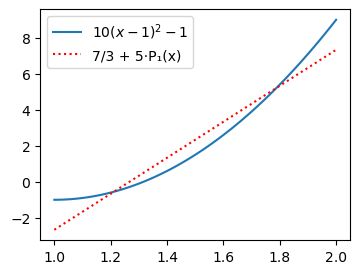

In [11]:
from numpy.polynomial import Legendre
plt.figure(figsize=(4, 3))
xj = np.linspace(1, 2, 100)
Xj = -1 + 2/(b-a)*(xj-a)
plt.plot(xj, sp.lambdify(x, u)(xj))
plt.plot(xj, uhat(u, 0) + uhat(u, 1)*Xj, 'r:')
plt.legend(['$10(x-1)^2-1$', f'{Legendre((uhat(u, 0), uhat(u, 1)))}']);

We see that the result is exactly as before, which is not so strange since the span of this Legendre basis is still the space of all linear functions. But add one more Legendre coefficient and the approximation becomes exact because $u(x)$ is a second order polynomial.

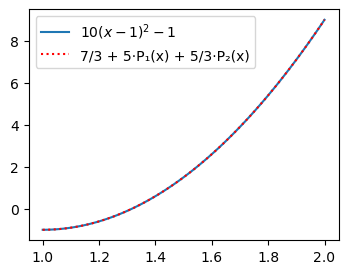

In [12]:
l2 = sp.lambdify(X, sp.legendre(2, X))
plt.figure(figsize=(4, 3))
plt.plot(xj, sp.lambdify(x, u)(xj))
plt.plot(xj, uhat(u, 0) + uhat(u, 1)*Xj + uhat(u, 2)*l2(Xj), 'r:')
plt.legend(['$10(x-1)^2-1$', f'{Legendre((uhat(u, 0), uhat(u, 1), uhat(u, 2)))}']);

```{note}
Adding one more Legendre coefficient does not change the first two.
```
```{note}
Note that we have not used any mesh points when computing the Legendre coefficients $\{\hat{u}_j\}_{j=0}^N$, only exact integrals.
```

In the computations above we have used Sympy and computed the inner product integral exactly. For some functions this may be impossible, or take a very long time. Hence, the inner products are often computed with numerical integration. We can rewrite the inner product above to use numerical integration (from scipy). The results are now almost identical, but no longer exact. See the difference below:

In [13]:
def ninner(u, v, domain=(-1, 1), x=x):
    from scipy.integrate import quadrature
    uv = sp.lambdify(x, u*v)
    return quadrature(uv, domain[0], domain[1])[0]

uhatn = lambda u, j: (2*j+1) * ninner(sp.legendre(j, X), 
                                      u.subs(x, (a+b+(b-a)*X)/2), 
                                      (-1, 1), x=X)/2
display((uhat(10*(x-1)**2-1, 0), uhatn(10*(x-1)**2-1, 0)))
display((uhat(10*(x-1)**2-1, 1), uhatn(10*(x-1)**2-1, 1)))

(7/3, 2.3333333333333335)

(5, 5.000000000000002)

The numerical integration routine [quadrature](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quadrature.html) is using adaptive quadrature in order to solve the integral. This adaptive integration routine is using a gradually finer mesh until the results of the integration are no longer improving more than a certain tolerance. The default tolerances (both relative and absolute) are $1.49 \cdot 10^{-8}$, but may also be set by the user.

### The collocation method 

The collocation method takes a very different approach, but the objective is still to find $u_N(x) \in V_N$ such that

$$
u_N(x) = \sum_{j=0}^N \hat{u}_j \psi_j(x).
$$

The collocation method requires that for some $N+1$ chosen mesh points $x_j$ the following $N+1$ equations are satisfied

$$
u(x_j) - u_N(x_j) = 0, \quad j \in (0, 1, \ldots, N).
$$

Inserting for $u_N(x)$ we get the $N+1$ equations

$$
\sum_{j=0}^N \hat{u}_j \psi_{j}(x_i) = u(x_i), \quad i \in (0, 1, \ldots, N),
$$

which can be written as the linear algebra system

$$
 \sum_{j} a_{ij} \hat{u}_j = u_i,
$$

where the matrix components $a_{ij} = \psi_j(x_i)$ and $u_i = u(x_i)$.

The Lagrange interpolation method described in [lecture 7](https://matmek-4270.github.io/matmek4270-book/lecture7.html#lagrange-interpolation-polynomials) is a collocation method. The Lagrange basis functions

$$
\ell_j(x) = \prod_{\substack{0 \le m \le N \\ m \ne j}} \frac{x-x_m}{x_j-x_m},
$$

are defined such that

$$
\ell_j(x_i) = \delta_{ij} = \begin{cases} 1 \text{ for } i=j \\
0 \text{ for }  i\ne j.
\end{cases}
$$

Hence for the Lagrange interpolation method the matrix $A$ is the identity matrix and we can simply use the coefficients

$$
\hat{u}_j = u(x_j).
$$

There is no integration and the method is often favoured for its simplicity. There is a problem though. How do you choose the collocation points?!

Lets return to the example with $u(x)=10(x-1)^2-1$ and $x \in [1, 2]$. The approximation using two collocation points (linear function) is now

$$
u_N(x) = \hat{u}_0 \ell_0(x) + \hat{u}_1 \ell_1(x),
$$

or more simply

$$
u_N(x) = u(x_0) \ell_0(x) + u(x_1) \ell_1(x).
$$

We can choose the end points $[x_0, x_1] = [1, 2]$ and reuse the two functions `Lagrangebasis` and `Lagrangefunction` from [lecture 7](https://matmek-4270.github.io/matmek4270-book/lecture7.html#lagrange-interpolation-polynomials). The result is then as shown below.

In [14]:
def Lagrangebasis(xj, x=x):
    """Construct Lagrange basis function for points in xj
    
    Parameters
    ----------
    xj : array
        Interpolation points
    x : Sympy Symbol
    
    Returns
    -------
    Lagrange basis functions
    """
    from sympy import Mul
    n = len(xj)
    ell = []
    numert = Mul(*[x - xj[i] for i in range(n)])

    for i in range(n):
        numer = numert/(x - xj[i])
        denom = Mul(*[(xj[i] - xj[j]) for j in range(n) if i != j])
        ell.append(numer/denom)
    return ell

def Lagrangefunction(u, basis):
    """Return Lagrange polynomial
    
    Parameters
    ----------
    u : array
        Mesh function values
    basis : tuple of Lagrange basis functions
        Output from Lagrangebasis
    """
    f = 0
    for j, uj in enumerate(u):
        f += basis[j]*uj
    return f

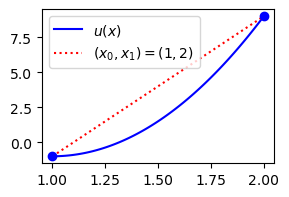

In [15]:
xj = np.linspace(1, 2, 100)
u = 10*(x-1)**2-1
ell = Lagrangebasis([1, 2])
L = Lagrangefunction([u.subs(x, 1), u.subs(x, 2)], ell)
plt.figure(figsize=(3, 2))
plt.plot(xj, sp.lambdify(x, u)(xj), 'b')
plt.plot(xj, sp.lambdify(x, L)(xj), 'r:')
plt.plot([1, 2], [u.subs(x, 1), u.subs(x, 2)], 'bo')
plt.legend(['$u(x)$', '$(x_0, x_1) = (1, 2)$']);

So this seems to be less accurate than the Galerkin method or the least squares method. However, we have not done any integration, and the lower accuracy has come very easily. We can also very easily use one more point and end up with a perfect approximation:

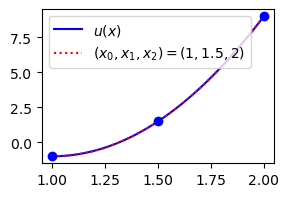

In [16]:
ell = Lagrangebasis([1, 1.5, 2])
L = Lagrangefunction([u.subs(x, 1), u.subs(x, 1.5), u.subs(x, 2)], ell)
plt.figure(figsize=(3, 2))
plt.plot(xj, sp.lambdify(x, u)(xj), 'b')
plt.plot(xj, sp.lambdify(x, L)(xj), 'r:')
plt.plot([1, 1.5, 2], [u.subs(x, 1), u.subs(x, 1.5), u.subs(x, 2)], 'bo')
plt.legend(['$u(x)$', '$(x_0, x_1, x_2) = (1, 1.5, 2)$']);

Lets consider a more difficult function

$$
u(x) = \frac{1}{1+16x^2}, \quad x \in [-1, 1]
$$

and attempt to approximate this function with Lagrange polynomials on a uniform grid.

In [17]:
u = 1/(1+16*x**2)
N = 16
xj = np.linspace(-1, 1, N+1)
uj = sp.lambdify(x, u)(xj)
ell = Lagrangebasis(xj)
L = Lagrangefunction(uj, ell)

Plot on a fine grid to plot in between mesh points. We know the Lagrange polynomial is exact on the mesh points.

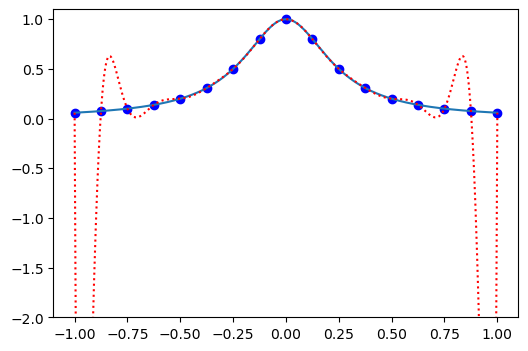

In [18]:
yj = np.linspace(-1, 1, 1000)
plt.figure(figsize=(6, 4))
plt.plot(xj, uj, 'bo')
plt.plot(yj, sp.lambdify(x, u)(yj))
plt.plot(yj, sp.lambdify(x, L)(yj), 'r:')
ax = plt.gca()
ax.set_ylim(-2, 1.1);

Ok, so that did not work out well! Large over and under-shoots in between the mesh points. So Lagrange polynomials are bad, right?

It turns out that due to something called [Runge's phenomenon](https://en.wikipedia.org/wiki/Runge%27s_phenomenon) it is a very bad idea to interpolate on a uniform mesh.

Lets try something else and use a clustering of points near the two edges. Chebyshev points are defined as

$$
x_j = \cos(j \pi / N), \quad j \in (0, 1, \ldots, N).
$$

Use these mesh points for the Lagrange polynomials and plot the results:

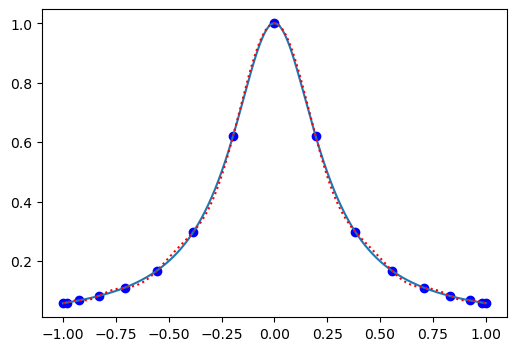

In [19]:
xj = np.cos(np.arange(N+1)*np.pi/N)
uj = sp.lambdify(x, u)(xj)
ell = Lagrangebasis(xj)
L = Lagrangefunction(uj, ell)
plt.figure(figsize=(6, 4))
plt.plot(xj, uj, 'bo')
plt.plot(yj, sp.lambdify(x, u)(yj))
plt.plot(yj, sp.lambdify(x, L)(yj), 'r:');

The agreement is now much better. And the agreement will become better and better the more points you use. Whereas for a uniform grid the agreement will become worse and worse the more points you use.

How about Legendre polynomials? The domain is $[-1, 1]$ so we can get the Legendre coefficients simply as

$$
\hat{u}_i = \frac{2i+1}{2}(u(x), P_i).
$$

Compute the first 40 Legendre coefficients and plot them

In [20]:
uj = lambda u, j: (2*j+1) * inner(sp.legendre(j, x), u, (-1, 1))/2
ul = []
for n in range(40):
    ul.append(uj(u, n).n())

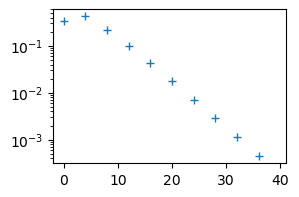

In [21]:
plt.figure(figsize=(3, 2))
plt.semilogy(ul, '+');

Notice that the Legendre coefficients are decreasing. This is because the series is converging.

### Boundary issues 

Lets consider a slightly different problem

$$
u(x) = 10(x-1)^2 -1, \quad x \in [0, 1]
$$

and attempt to find $u_N \in V_N = \text{span}\{\sin((j+1)\pi x)\}_{j=0}^N$ with the Galerkin method.

The sines are orthogonal such that the mass matrix becomes diagonal

$$
\int_0^1 \sin((j+1) \pi x) \sin((i + 1) \pi x) dx = \frac{1}{2} \delta_{ij}.
$$

Hence we can easily get the coefficients with the Galerkin method

$$
\hat{u}_i = 2 \left( u(x),  \sin((i+1) \pi x) \right)_{L^2([0, 1])}.
$$(eq-hatusin)

Lets implement and check the results:

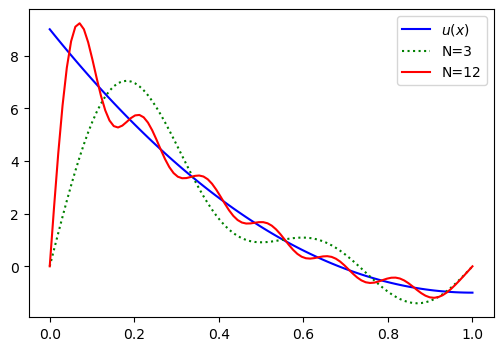

In [22]:
u = 10*(x-1)**2-1
uhat = lambda u, i: 2*inner(u, sp.sin((i+1)*sp.pi*x), (0, 1))
ul = []
for i in range(15):
    ul.append(uhat(u, i).n())

ul = np.array(ul, dtype=float)
def uN(uh, xj):
    N = len(xj)
    uj = np.zeros(N)
    for i, ui in enumerate(uh):
        uj[:] += ui*np.sin((i+1)*np.pi*xj)
    return uj

xj = np.linspace(0, 1, 100)
plt.figure(figsize=(6,4))
plt.plot(xj, 10*(xj-1)**2-1, 'b')
plt.plot(xj, uN(ul[:(3+1)], xj), 'g:')
plt.plot(xj, uN(ul[:(12+1)], xj), 'r-')
plt.legend(['$u(x)$', 'N=3', 'N=12']);

Evidently, we get large oscillations and the solution does not seem to converge. The problem is that the basis functions are all such that

$$
\psi_j(0) = \psi_j(1) = 1
$$

since $\sin((j+1) \pi x) = 0$ for $x =0$ and $x=1$.  So no matter how many basis functions and unknown we're adding, the sum

$$
u_N(x) = \sum_{j=0}^N \hat{u}_j \sin((j+1) \pi x)
$$

will allways lead to $u_N(0) = 0$ and $u_N(1) = 0$. We have a problem with the basis functions having the wrong values at the boundaries.

A possible solution to this problem is to add a function to the right hand side above that satisfies the boundary conditions:

$$
u_N(x) = b(x) + \sum_{j=0}^N \hat{u}_j \sin((j+1) \pi x)
$$

where $b(0) = u(0)$ and $b(1) = u(1)$. This automatically leads to the correct solution $u_N(0) = b(0) = u(0)$ and $u_N(1)=b(1)=u(1)$. For our example we can simply use use $b(x) = u(0)(1-x) + u(1)x$. Hence, there are no new unknowns, only new basis functions.

If we now define the slightly modified trial space: $W_N = \text{span}\{b(x)+\sin((j+1)\pi x)\}_{j=0}^N$, we get the variational problem: find $u_N \in W_N$ such that

$$
(u-u_N, v) = 0, \quad \forall \, v \in V_N
$$

where $V_N = \{\sin((j+1)\pi x)\}_{j=0}^N$. We get

$$
\left(u- \sum_{j=0}^N b(x)+\sin((j+1)\pi x), \sin((i+1)\pi x) \right) = 0, \quad i \in (0, 1, \ldots, N)
$$

and using the orthogonality of the sines we get

$$
\hat{u}_i = \left(u(x)-b(x), \sin((i+1)\pi x) \right) \quad i \in (0, 1, \ldots, N).
$$

Compared with Eq. {eq}`eq-hatusin` this is only a minor modification, but it makes a world of difference. Lets implement it:

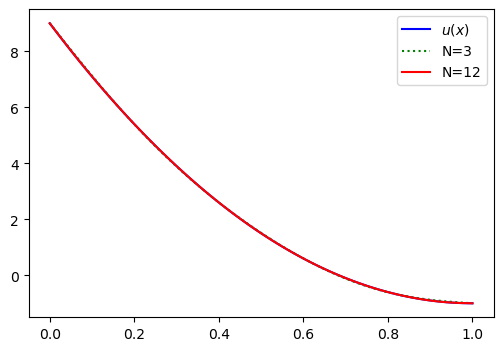

In [23]:
uc = []
b = u.subs(x, 0)*(1-x) + u.subs(x, 1)*x
for i in range(15):
    uc.append(uhat(u-b, i).n())

uc = np.array(uc, dtype=float)
def uNc(uh, xj):
    N = len(xj)
    uj = u.subs(x, 0)*(1-xj) + u.subs(x, 1)*xj
    for i, ui in enumerate(uh):
        uj[:] += ui*np.sin((i+1)*np.pi*xj)
    return uj

plt.figure(figsize=(6,4))
plt.plot(xj, 10*(xj-1)**2-1, 'b')
plt.plot(xj, uNc(uc[:(3+1)], xj), 'g:')
plt.plot(xj, uNc(uc[:(12+1)], xj), 'r-')
plt.legend(['$u(x)$', 'N=3', 'N=12']);

Notice the very good agreement. The expansion coefficients are now converging, which we can see by printing out the 15 computed values

In [24]:
print(uc)

[-2.58012275e+00  0.00000000e+00 -9.55601020e-02  0.00000000e+00
 -2.06409820e-02  0.00000000e+00 -7.52222377e-03  0.00000000e+00
 -3.53926304e-03  0.00000000e+00 -1.93848441e-03  0.00000000e+00
 -1.17438450e-03  0.00000000e+00 -7.64480816e-04]


These should be compared with the expansion coefficients without the boundary adjustment:

In [25]:
print(ul)

[2.51283542 3.18309886 1.60209262 1.59154943 0.99795065 1.06103295
 0.72004323 0.79577472 0.56234498 0.63661977 0.46105771 0.53051648
 0.39059163 0.45472841 0.33876606]


The sine basis functions need modification because they are are all zero on the boundary. 
Legendre polynomials, on the other hand, can be used without any boundary adjustments since

$$
P_j(-1) = (-1)^j \quad \text{and} \quad P_j(1) = 1.
$$

We get a minor modification to the Legendre coefficients because of the new physical domain, but otherwise there is no issue and we get a perfect approximation using three Legendre polynomials:

In [27]:
a, b = 0, 1
uhat = lambda u, j: (2*j+1) * inner(sp.legendre(j, X), 
                                    u.subs(x, (a+b+(b-a)*X)/2), 
                                    (-1, 1), x=X)/2
uL = [] 
for i in range(6):
    uL.append(uhat(u, i))
print(uL)

[7/3, -5, 5/3, 0, 0, 0]
